In [148]:
import math

import random

import matplotlib.pyplot as plt

%matplotlib inline

### Data preparation

In [149]:
def read_csv(path, train_test_ratio=0.8):
    
    with open(path) as f:
        lines = f.readlines()[1:]
        
    random.shuffle(lines)
    
    x, y = [], []    
        
    for line in lines:                        
        if 'NA' in line:
            continue
        
        line = line.split(',')
        
        features = line[:4]
        features[1] = float(features[1])
        features[2] = float(features[2])
        features[3] = float(features[3])                
        
        line[4] = 1 if line[4].strip() == '"TRUE"' else 0
        
        x.append(features)
        y.append(line[4])
    
    train_set_size = int(len(x) * train_test_ratio)           
    
    train_x = x[:train_set_size]
    train_y = y[:train_set_size]
    test_x = x[train_set_size:]
    test_y = y[train_set_size:]        
    
        
    return train_x, train_y, test_x, test_y

In [150]:
train_x, train_y, test_x, test_y = read_csv('dataset/seattleWeather_1948-2017.csv')

In [151]:
len(train_x), len(test_x)

(20438, 5110)

In [152]:
# inspect data for normalization

mins = [float('inf')] * 3
maxs = [float('-inf')] * 3

for line in train_x:    
    for i, value in enumerate(line[1:]):
        mins[i] = min(mins[i], value)
        maxs[i] = max(maxs[i], value)

        
mins, maxs

([0.0, 16.0, 0.0], [5.02, 103.0, 71.0])

In [153]:
# normalize input

def prepare(x):
    x = x[1:]
    
    for i in range(len(x)):
        x[i] = (x[i] - mins[i]) / (maxs[i] - mins[i])
    
    return x

In [154]:
train_x_normalized = []

for x in train_x:
    train_x_normalized.append(prepare(x))

### Logistic Regression

In [155]:
def sigmoid_scalar(x):
    # to avoid overflow
    if x < 0:
        sigmoid = math.exp(x) / (1 + math.exp(x))
    else:
        sigmoid = 1 / (1 + math.exp(-x))

    # to handle machine precision errors
    sigmoid = max(0.0001, sigmoid)
    sigmoid = min(0.9999, sigmoid)

    return sigmoid

In [156]:
def predict(sample_x, weights):
    # calculate z = sum(w * x + b)
    # here bias (b) is also included in weights
    z = 0
    for x, w in zip(sample_x, weights):
        z += w * x

    # sigmoid(z)
    return sigmoid_scalar(z)

In [157]:
def cross_entropy_loss(predicted_value, actual_value):
    y = actual_value
    y_pred = predicted_value    

    if y == 1:        
        return -math.log(y_pred)

    else:        
        return -math.log(1 - y_pred)

In [158]:
def gradient_decent(X, label, weights=None, learning_rate=0.1):
    n_features = len(X[0])

    # initialize weight with random values (equal length to x's features)
    if weights == None:
        weights = [random.random() for _ in range(n_features)]

    loss = 0

    for x, y in zip(X, label):
        y_pred = predict(x, weights)
        loss += cross_entropy_loss(y_pred, y)

        # dw = (y_pred - y) * x
        # weight = weight - learning_rate * dw
        err = y_pred - y
        for i in range(n_features):
            dw_i = err * x[i]
            weights[i] -= learning_rate * dw_i

    return weights, loss / len(X)

In [159]:
def train_binary_class(x_train, y_train, learning_rate, epoch, verbose=False):
    weights = None

    # for graphing
    history = []

    for i in range(epoch):
        weights, loss = gradient_decent(x_train, y_train, weights, learning_rate)

        history.append(loss)

        if verbose:
            print(f"Epoch [{i}]\n\t- Cross entropy loss: {loss}")

    return weights, history

In [160]:
def predict_class(sample_x, model):
    if predict(sample_x, model) > 0.5:
        return 1
    return 0
    

In [161]:
def test(x_test, y_test, model):        
    net_accuracy = 0

    for i in range(len(x_test)):
        
        prediction = predict_class(x_test[i], model)
        
        if prediction == y_test[i]:
            net_accuracy += 1

    return net_accuracy / len(x_test)

In [162]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0, 1.5]

epochs = 100

histories = []

for eta in learning_rates:
    print(f'\nLearning rate: {eta}')
    
    model, history = train_binary_class(train_x_normalized, train_y, eta, epochs, verbose=True)
    
    histories.append((model, history))
            


Learning rate: 0.0001
Epoch [0]
	- Cross entropy loss: 0.6879855259891694
Epoch [1]
	- Cross entropy loss: 0.6778410001332603
Epoch [2]
	- Cross entropy loss: 0.67233480909798
Epoch [3]
	- Cross entropy loss: 0.6691506385304556
Epoch [4]
	- Cross entropy loss: 0.6671355078995663
Epoch [5]
	- Cross entropy loss: 0.6657135121007287
Epoch [6]
	- Cross entropy loss: 0.6645951055899827
Epoch [7]
	- Cross entropy loss: 0.6636337216495976
Epoch [8]
	- Cross entropy loss: 0.6627547147729826
Epoch [9]
	- Cross entropy loss: 0.6619198686964193
Epoch [10]
	- Cross entropy loss: 0.6611095284663899
Epoch [11]
	- Cross entropy loss: 0.6603135427705809
Epoch [12]
	- Cross entropy loss: 0.659526646136912
Epoch [13]
	- Cross entropy loss: 0.6587460937706516
Epoch [14]
	- Cross entropy loss: 0.6579704455694476
Epoch [15]
	- Cross entropy loss: 0.6571989389504401
Epoch [16]
	- Cross entropy loss: 0.656431164432592
Epoch [17]
	- Cross entropy loss: 0.6556668973461441
Epoch [18]
	- Cross entropy loss: 0.6

Epoch [57]
	- Cross entropy loss: 0.4760736089545605
Epoch [58]
	- Cross entropy loss: 0.4748198075993295
Epoch [59]
	- Cross entropy loss: 0.4735934241069254
Epoch [60]
	- Cross entropy loss: 0.4723935577265811
Epoch [61]
	- Cross entropy loss: 0.4712193450151271
Epoch [62]
	- Cross entropy loss: 0.4700699579970703
Epoch [63]
	- Cross entropy loss: 0.46894460242850994
Epoch [64]
	- Cross entropy loss: 0.4678425161584646
Epoch [65]
	- Cross entropy loss: 0.4667629675815455
Epoch [66]
	- Cross entropy loss: 0.4657052541762455
Epoch [67]
	- Cross entropy loss: 0.4646687011237084
Epoch [68]
	- Cross entropy loss: 0.46365266000185995
Epoch [69]
	- Cross entropy loss: 0.4626565075504939
Epoch [70]
	- Cross entropy loss: 0.46167964450287163
Epoch [71]
	- Cross entropy loss: 0.46072149447989763
Epoch [72]
	- Cross entropy loss: 0.45978150294310133
Epoch [73]
	- Cross entropy loss: 0.4588591362029127
Epoch [74]
	- Cross entropy loss: 0.45795388047896524
Epoch [75]
	- Cross entropy loss: 0.4570

Epoch [12]
	- Cross entropy loss: 0.31912932043952424
Epoch [13]
	- Cross entropy loss: 0.3153478777245003
Epoch [14]
	- Cross entropy loss: 0.31183599187073335
Epoch [15]
	- Cross entropy loss: 0.30855913079475766
Epoch [16]
	- Cross entropy loss: 0.30548886903333755
Epoch [17]
	- Cross entropy loss: 0.30260155954674006
Epoch [18]
	- Cross entropy loss: 0.2998773334472579
Epoch [19]
	- Cross entropy loss: 0.2972993568831461
Epoch [20]
	- Cross entropy loss: 0.2948532319054331
Epoch [21]
	- Cross entropy loss: 0.2925265569307575
Epoch [22]
	- Cross entropy loss: 0.2903085840535441
Epoch [23]
	- Cross entropy loss: 0.28818994536325987
Epoch [24]
	- Cross entropy loss: 0.2861624156614277
Epoch [25]
	- Cross entropy loss: 0.28421873934528125
Epoch [26]
	- Cross entropy loss: 0.2823524839389039
Epoch [27]
	- Cross entropy loss: 0.28055791942176
Epoch [28]
	- Cross entropy loss: 0.27882993935663697
Epoch [29]
	- Cross entropy loss: 0.2771639502585472
Epoch [30]
	- Cross entropy loss: 0.2755

Epoch [66]
	- Cross entropy loss: 0.14543348389607683
Epoch [67]
	- Cross entropy loss: 0.14483270944485024
Epoch [68]
	- Cross entropy loss: 0.14424136015822492
Epoch [69]
	- Cross entropy loss: 0.14365914991398593
Epoch [70]
	- Cross entropy loss: 0.14308580621275707
Epoch [71]
	- Cross entropy loss: 0.14252106853944216
Epoch [72]
	- Cross entropy loss: 0.14196468534487675
Epoch [73]
	- Cross entropy loss: 0.1414164199124097
Epoch [74]
	- Cross entropy loss: 0.14087604226930273
Epoch [75]
	- Cross entropy loss: 0.14034333352151335
Epoch [76]
	- Cross entropy loss: 0.1398180837050349
Epoch [77]
	- Cross entropy loss: 0.13930009163145235
Epoch [78]
	- Cross entropy loss: 0.1387891632634279
Epoch [79]
	- Cross entropy loss: 0.13828511175224
Epoch [80]
	- Cross entropy loss: 0.13778775893337075
Epoch [81]
	- Cross entropy loss: 0.13729693228876702
Epoch [82]
	- Cross entropy loss: 0.13681246779333528
Epoch [83]
	- Cross entropy loss: 0.13633420625484483
Epoch [84]
	- Cross entropy loss: 

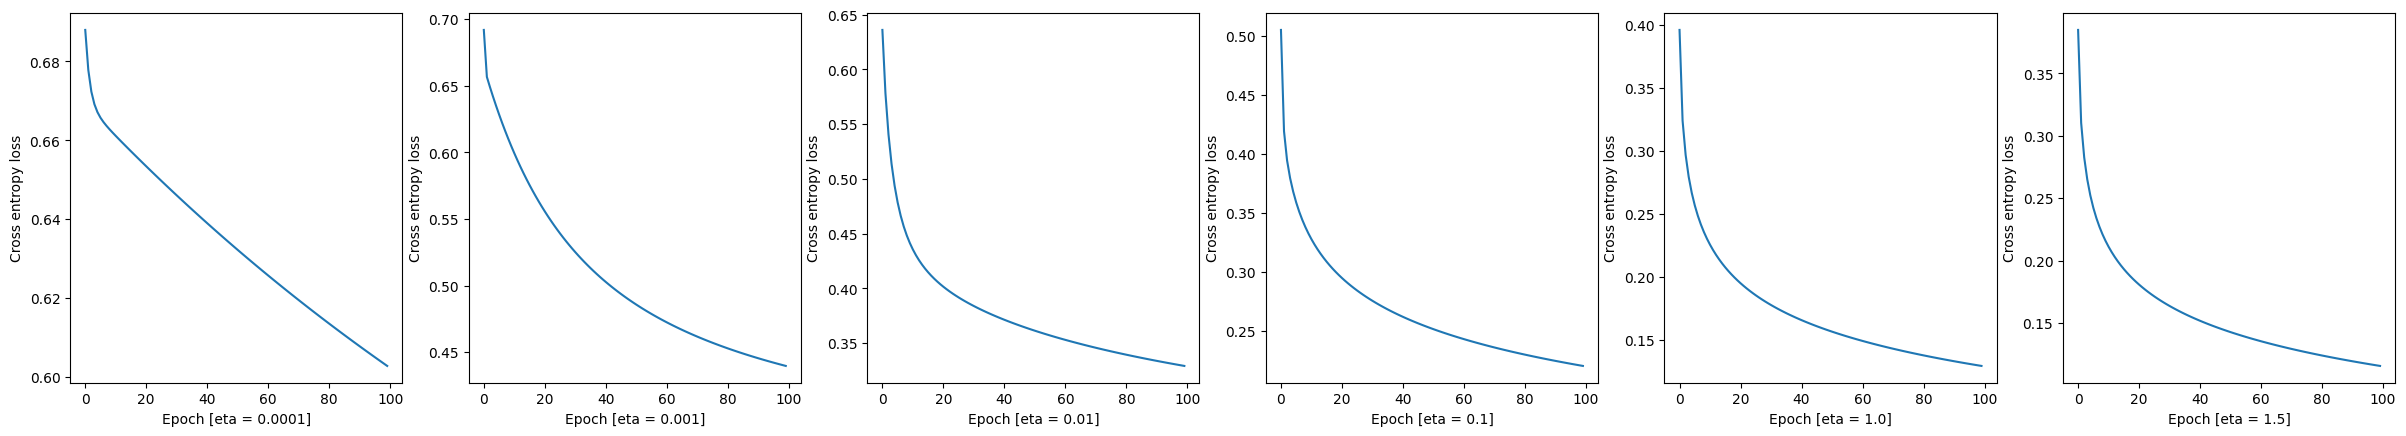

In [163]:
# draw training history for each learing rates

fig, axs = plt.subplots(nrows=1, ncols=len(learning_rates))
fig.set_figwidth(30)
    
for i, ax in enumerate(axs.flat):
    
    ax.set_xlabel(f'Epoch [eta = {learning_rates[i]}]')
    ax.set_ylabel(f'Cross entropy loss')

    ax.plot(range(100), histories[i][1])

In [168]:
test_x_normalized = list(map(prepare, test_x))

accuracy = []
for i, eta in enumerate(learning_rates):    
    acc = test(test_x_normalized, test_y, histories[i][0])
    accuracy.append(acc)
    print(f'Learning rate: {eta} \tAccuracy: {acc}')

Learning rate: 0.0001 	Accuracy: 0.673972602739726
Learning rate: 0.001 	Accuracy: 0.8070450097847358
Learning rate: 0.01 	Accuracy: 0.8563600782778865
Learning rate: 0.1 	Accuracy: 0.9174168297455969
Learning rate: 1.0 	Accuracy: 0.9516634050880626
Learning rate: 1.5 	Accuracy: 0.9565557729941292


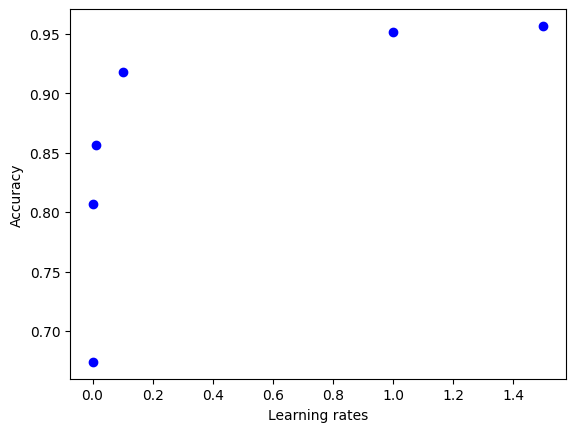

In [178]:
# draw accuracy vs learning rate

plt.xlabel('Learning rates')
plt.ylabel('Accuracy')
plt.plot(learning_rates, accuracy, 'bo')